<h3> Подключаем библиотеки

In [94]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [95]:
data_train = pd.read_csv('train.csv')
data_valid = pd.read_csv('valid.csv')

C:\Users\slava\AppData\Local\Temp\ipykernel_10720\326463787.py:1: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1279,1280,1281,1282,1447,1448,1449,1450

In [96]:
numeric_columns = data_train.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_train.select_dtypes(include=['object']).columns
boolean_columns = data_train.select_dtypes(include=['bool']).columns

print(f"Числовые колонки в train.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в train.csv: {len(categorical_columns)}")
print(f"Булевые колонки в train.csv: {len(boolean_columns)}")

numeric_columns = data_valid.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = data_valid.select_dtypes(include=['object']).columns
boolean_columns = data_valid.select_dtypes(include=['bool']).columns

print("")
print(f"Числовые колонки в valid.csv: {len(numeric_columns)}")
print(f"Категориальные колонки в valid.csv: {len(categorical_columns)}")
print(f"Булевые колонки в valid.csv: {len(boolean_columns)}")

Числовые колонки в train.csv: 2319
Категориальные колонки в train.csv: 347
Булевые колонки в train.csv: 0

Числовые колонки в valid.csv: 2332
Категориальные колонки в valid.csv: 334
Булевые колонки в valid.csv: 0


<h3> Очистка данных

In [97]:
# Сначала группируем по client_id, объединяя строки, заполняя пропуски значениями из других строк
data_cleaned_train = data_train.groupby('client_id', as_index=False).apply(lambda group: group.ffill().bfill().iloc[0])
data_cleaned_valid = data_valid.groupby('client_id', as_index=False).apply(lambda group: group.ffill().bfill().iloc[0])

# Убедимся, что в результате не осталось дубликатов
data_cleaned_train = data_cleaned_train.drop_duplicates(subset='client_id')
data_cleaned_valid = data_cleaned_valid.drop_duplicates(subset='client_id')


C:\Users\slava\AppData\Local\Temp\ipykernel_10720\665574341.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_cleaned_train = data_train.groupby('client_id', as_index=False).apply(lambda group: group.ffill().bfill().iloc[0])
C:\Users\slava\AppData\Local\Temp\ipykernel_10720\665574341.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned_train = data_train.groupby('client_id', as_index=False).apply(lambda group: group.ffill().bfill().iloc[0])
C:\Users\slava\AppDat

In [98]:
# Удаление колонок, где все значения NaN
data_cleaned_train = data_cleaned_train.dropna(axis=1, how='all')
data_cleaned_train = data_cleaned_train.loc[:, (data_cleaned_train.notna()).mean() > 0.75]
data_cleaned_train = data_cleaned_train.drop_duplicates()
data_cleaned_train = data_cleaned_train[data_cleaned_train.notna().mean(axis=1) > 0.75]

data_cleaned_valid = data_cleaned_valid.dropna(axis=1, how='all')
# data_cleaned_valid = data_cleaned_valid.loc[:, (data_cleaned_valid.notna()).mean() > 0.75]
data_cleaned_valid = data_cleaned_valid.drop_duplicates()
# data_cleaned_valid = data_cleaned_valid[data_cleaned_valid.notna().mean(axis=1) > 0.75]

numeric_columns_train = data_cleaned_train.select_dtypes(include=['int64', 'float64']).columns
# numeric_columns_valid = data_cleaned_valid.select_dtypes(include=['int64', 'float64']).columns

# Заполняем пропуски только в числовых столбцах
imputer = SimpleImputer(strategy='median')
data_cleaned_train[numeric_columns_train] = imputer.fit_transform(data_cleaned_train[numeric_columns_train])
# data_cleaned_valid[numeric_columns_valid] = imputer.fit_transform(data_cleaned_valid[numeric_columns_valid])

# Сравнение до и после удаления
print(f"До удаления колонок (train.csv): {data_train.shape[1]} колонок")
print(f"После удаления колонок (train.csv): {data_cleaned_train.shape[1]} колонок")
print(f"Число строк до удаления (train.csv): {data_train.shape[0]}")
print(f"Число строк после удаления (train.csv): {data_cleaned_train.shape[0]}\n")
print(f"До удаления колонок (valid.csv): {data_valid.shape[1]} колонок")
print(f"После удаления колонок (valid.csv): {data_cleaned_valid.shape[1]} колонок")
print(f"Число строк до удаления (valid.csv): {data_valid.shape[0]}")
print(f"Число строк после удаления (valid.csv): {data_cleaned_valid.shape[0]}")

До удаления колонок (train.csv): 2666 колонок
После удаления колонок (train.csv): 272 колонок
Число строк до удаления (train.csv): 14456
Число строк после удаления (train.csv): 4661

До удаления колонок (valid.csv): 2666 колонок
После удаления колонок (valid.csv): 2581 колонок
Число строк до удаления (valid.csv): 3642
Число строк после удаления (valid.csv): 2932


In [99]:
test_data = data_cleaned_valid.copy()
test_data = test_data.dropna(axis=1, how='all')
# data_cleaned_valid = data_cleaned_valid.loc[:, (data_cleaned_valid.notna()).mean() > 0.75]
test_data = test_data.drop_duplicates()
print(f"До удаления колонок(valid.csv): {data_valid.shape[1]} колонок")
print(f"После удаления колонок(valid.csv): {test_data.shape[1]} колонок")
print(f"Число строк до удаления (valid.csv): {data_valid.shape[0]}")
print(f"Число строк после удаления (valid.csv): {test_data.shape[0]}\n")

До удаления колонок(valid.csv): 2666 колонок
После удаления колонок(valid.csv): 2581 колонок
Число строк до удаления (valid.csv): 3642
Число строк после удаления (valid.csv): 2932



<h3> Сохраняем очищенные данные

In [100]:
data_cleaned_train.to_csv('cleaned_train.csv', index=False)
data_cleaned_valid.to_csv('cleaned_valid.csv', index=False)

<h3> Обучаем модель

Баланс классов в целевой переменной:
target
0.0    0.981334
1.0    0.018666
Name: proportion, dtype: float64


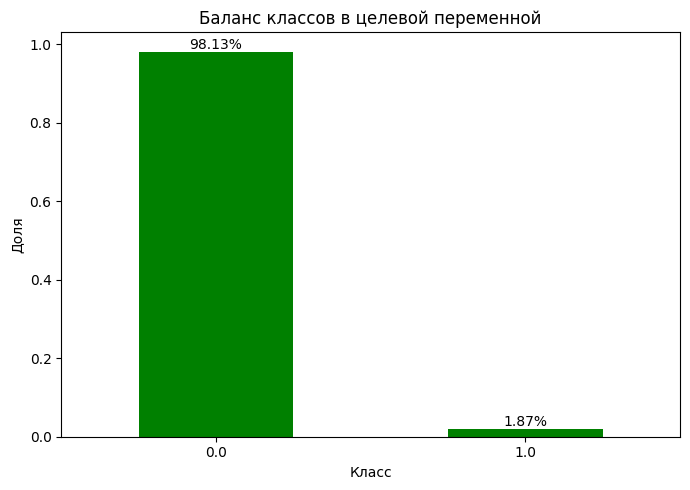

In [101]:
numeric_df_train = data_cleaned_train.select_dtypes(include=[np.number])
numeric_df_valid = test_data.select_dtypes(include=[np.number])
# Пример (должны быть признаки и целевая переменная)
X_train = numeric_df_train.drop(columns=['target', 'client_id'])  # Признаки
y_train = data_cleaned_train['target']                # Целевая переменная

# Вывод баланса классов для целевой переменной
class_balance = y_train.value_counts(normalize=True)
print("Баланс классов в целевой переменной:")
print(class_balance)

# Визуализация баланса классов
plt.figure(figsize=(7, 5))
class_balance.plot(kind='bar', color='green')
plt.title('Баланс классов в целевой переменной')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
for f, e in enumerate(class_balance):
    plt.text(f, e, f'{e:.2%}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [102]:
# Масштабирование данных для PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Применение PCA
pca = PCA(n_components=0.95)  # Сохраняем 95% дисперсии
X_pca = pca.fit_transform(X_scaled)

# Получение важности признаков после PCA
pca_components = pd.DataFrame(pca.components_, columns=X_train.columns)
pca_importances = pca_components.abs().mean(axis=0)  # Средняя важность признаков
top_pca_features = pca_importances[pca_importances != 0].sort_values(ascending=False)
print("Топ-20 признаков по PCA:\n", top_pca_features, '\n')

# RandomForest для исходных данных
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Получение важности признаков по RandomForest
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Фильтрация признаков по важности в RandomForest (больше 0.01)
top_rf_features = rf_importances[rf_importances > 0.01].sort_values(ascending=False)
print("Признаки по RandomForest:\n", top_rf_features, '\n')

# Объединение результатов PCA и RandomForest
important_features = set(top_pca_features.index).union(set(top_rf_features.index))
important_features = list(important_features)
print("Общие важные признаки (PCA + RandomForest):\n", important_features)
print("Количество общих признаков:", len(important_features))


Топ-20 признаков по PCA:
 col2470    9.357216e-02
col2175    8.802114e-02
col1503    8.713404e-02
col2663    8.638812e-02
col2215    8.152632e-02
               ...     
col1580    7.402376e-37
col1585    6.412368e-49
col1583    2.963928e-49
col1586    1.188528e-49
col1584    4.442761e-55
Length: 207, dtype: float64 

Признаки по RandomForest:
 col2663    0.033715
col2336    0.024207
col2340    0.023796
col2334    0.022733
col2341    0.021807
col2388    0.021771
col2335    0.021556
col2470    0.021261
col2342    0.021180
col2318    0.020971
col2390    0.020886
col2220    0.020882
col2389    0.020831
col2384    0.020734
col2383    0.020437
col2316    0.020210
col2311    0.020160
col2312    0.019989
col2222    0.019946
col2310    0.019903
col2216    0.019369
col2293    0.018888
col2468    0.018825
col2317    0.018438
col2214    0.017071
col2455    0.016532
col2382    0.016003
col2292    0.015997
col2294    0.015956
col2456    0.015745
col2454    0.015658
col2287    0.015568
col2288    0.

<h3> Тестируем модель

In [103]:
test_data = data_cleaned_valid.copy()
test_data = test_data[top_rf_features.index]
# pd.concat([data_cleaned_train, data_train['target']], axis=1)
test_data = pd.concat([test_data, data_cleaned_valid['target']], axis=1)
test_data = test_data[test_data.notna().mean(axis=1) > 0.75]
test_data[top_rf_features.index] = imputer.fit_transform(test_data[top_rf_features.index])
test_data

,col2663,col2336,col2340,col2334,col2341,col2388,col2335,col2470,col2342,col2318,...,col2294,col2456,col2454,col2287,col2288,col2462,col2286,col2460,col2461,target
0,0.256919,5794341.03,5794341.03,5794341.03,5794341.03,30.09,5794341.03,299.0,5.794341e+06,192567.0,...,5.000000,1.700000,1.70,5.0,5.000000,1.700000,5.0,1.70,1.70,0
1,0.267221,13971865.62,13981124.40,13981124.40,13953348.06,63.51,13953348.06,31.0,1.397187e+07,221704.0,...,3.333333,3.026667,3.79,2.0,3.333333,3.026667,4.0,3.79,1.50,0
2,0.256261,318565.86,7938208.75,318565.86,318565.86,38.75,318565.86,361.0,4.128387e+06,150118.0,...,3.500000,1.190000,1.26,4.0,4.000000,0.000000,4.0,0.00,0.00,0
5,0.257217,11139747.84,11139747.84,11139747.84,11139747.84,49.92,11139747.84,230.0,1.113975e+07,223152.0,...,21.000000,1.340000,1.34,21.0,21.000000,1.340000,21.0,1.34,1.34,0
6,0.318994,10570281.40,10570281.40,10570281.40,10570281.40,26.60,10570281.40,87.0,1.057028e+07,397379.0,...,4.000000,0.000000,0.00,4.0,4.000000,0.000000,4.0,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,0.276883,5896839.00,5896839.00,5896839.00,5896839.00,39.00,5896839.00,31.0,5.896839e+06,151201.0,...,6.000000,0.790000,0.79,6.0,6.000000,0.790000,6.0,0.79,0.79,0
2927,0.318385,14053793.40,14053793.40,14053793.40,14053793.40,51.90,14053793.40,16.0,1.405379e+07,270786.0,...,9.000000,0.000000,0.00,9.0,9.000000,0.000000,9.0,0.00,0.00,0
2928,0.261504,7355203.80,7355203.80,7355203.80,7355203.80,35.35,7355203.80,88.0,7.355204e+06,208068.0,...,1.000000,1.190000,1.26,1.0,1.000000,1.170000,1.0,1.28,1.13,0
2929,0.262651,5691475.20,5691475.20,5691475.20,5691475.20,35.43,5691475.20,282.0,5.691475e+06,160640.0,...,8.000000,1.330000,1.33,8.0,8.000000,1.330000,8.0,1.33,1.33,0


In [104]:
numeric_df_train[top_rf_features.index]

,col2663,col2336,col2340,col2334,col2341,col2388,col2335,col2470,col2342,col2318,...,col2292,col2294,col2456,col2454,col2287,col2288,col2462,col2286,col2460,col2461
0,0.256261,6.801884e+06,6801884.32,6801884.32,6801884.32,37.88,6801884.32,545.0,6.801884e+06,179564.0,...,15.0,15.0,0.00,0.00,15.0,15.0,0.00,15.0,0.00,0.00
1,0.256919,5.794341e+06,5794341.03,5794341.03,5794341.03,30.09,5794341.03,152.0,5.794341e+06,192567.0,...,5.0,5.0,1.70,1.70,5.0,5.0,1.70,5.0,1.70,1.70
2,0.256261,4.128387e+06,7938208.75,7938208.75,318565.86,38.75,318565.86,242.0,4.128387e+06,150118.0,...,4.0,3.5,0.00,0.00,3.0,3.5,0.00,4.0,0.00,0.00
3,0.256261,7.002418e+06,7002418.50,7002418.50,7002418.50,36.75,7002418.50,557.0,7.002418e+06,190542.0,...,16.0,16.0,2.10,2.10,16.0,16.0,2.10,16.0,2.10,2.10
4,0.258682,8.280004e+06,8280003.76,8280003.76,8280003.76,35.56,8280003.76,60.0,8.280004e+06,232846.0,...,8.0,8.0,1.40,1.40,8.0,8.0,1.40,8.0,1.40,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4812,0.258634,6.739217e+06,6739216.92,6739216.92,6739216.92,25.39,6739216.92,32.0,6.739217e+06,265428.0,...,11.0,11.0,2.67,2.67,11.0,11.0,2.67,11.0,2.67,2.67
4813,0.256261,7.099565e+06,7177196.38,7382024.44,7177196.38,35.54,6866406.46,399.0,7.177196e+06,201947.0,...,13.0,13.0,1.33,1.37,9.0,9.0,2.07,10.0,2.07,2.07
4814,0.258007,7.083043e+06,7083043.20,7083043.20,7083043.20,33.30,7083043.20,219.0,7.083043e+06,212704.0,...,18.0,18.0,2.01,2.01,18.0,18.0,2.01,18.0,2.01,2.01
4815,0.257217,4.863796e+06,4863796.20,4863796.20,4863796.20,24.84,4863796.20,95.0,4.863796e+06,195805.0,...,15.0,15.0,1.54,1.54,15.0,15.0,1.54,15.0,1.54,1.54


In [105]:
# Разделение данных на обучающую и тестовую выборки
X_train = numeric_df_train.drop(columns=['target', 'client_id'])
y_train = data_cleaned_train['target']
X_test = test_data.drop(columns=['target'])
y_test = test_data['target']

# Масштабирование данных для ElasticNet
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[top_rf_features.index])
X_test_scaled = scaler.transform(X_test)

# Обучение модели ElasticNet
elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=10000, random_state=42)
elastic_net.fit(X_train_scaled, y_train)
y_pred_elastic = elastic_net.predict(X_test_scaled)

# Обучение модели на сокращенных данных
rf_reduced = RandomForestClassifier(random_state=42)
rf_reduced.fit(X_train[top_rf_features.index], y_train)
y_pred_reduced = rf_reduced.predict(X_test[top_rf_features.index])

# Оценка качества
print("Метрики для ElasticNet:")
print("Accuracy:", accuracy_score(y_test, y_pred_elastic))
print("F1-score:", f1_score(y_test, y_pred_elastic))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_elastic))

print("\nМетрики для RandomForest:")
print("Accuracy:", accuracy_score(y_test, y_pred_reduced))
print("F1-score:", f1_score(y_test, y_pred_reduced))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_reduced))

Метрики для ElasticNet:
Accuracy: 0.9838935574229691
F1-score: 0.0
ROC-AUC: 0.4992892679459844

Метрики для RandomForest:
Accuracy: 0.9873949579831933
F1-score: 0.25
ROC-AUC: 0.5714285714285714


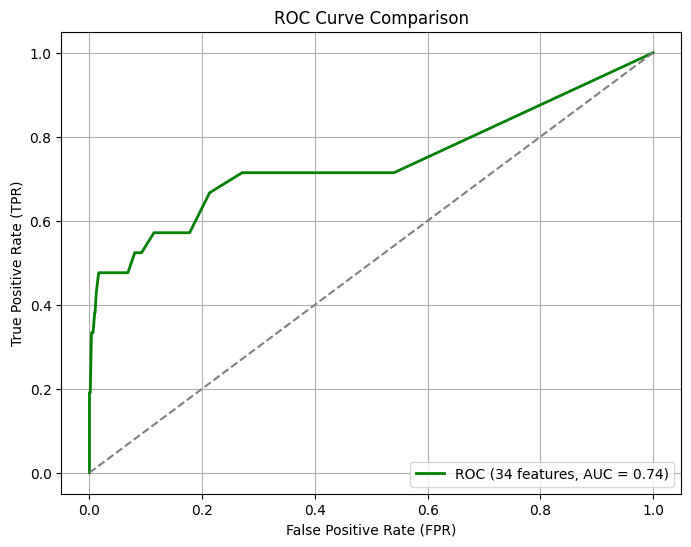

In [106]:
# Предсказания для модели RandomForest
y_pred_proba_reduced = rf_reduced.predict_proba(X_test[top_rf_features.index])[:, 1]
fpr_reduced, tpr_reduced, _ = roc_curve(y_test, y_pred_proba_reduced)
roc_auc_reduced = roc_auc_score(y_test, y_pred_proba_reduced)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_reduced, tpr_reduced, color='green', lw=2, label=f'ROC (34 features, AUC = {roc_auc_reduced:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Случайная классификация
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<h3> Сохраняем целевую переменную в тестируемых данных

In [107]:
# Сохранение предсказаний в целевой переменной
test_data['target'] = y_pred_reduced
test_data.to_csv('ready_valid.csv', index=False)